# Representación digital de imágenes

Una imagen digital es una matriz, o array multidimensional, de números en donde cada celda de la matriz es un píxel:

### Qué es un pixel?

El píxel representa el valor de una magnitud física.
- Cantidad de luz en un punto de una escena.
- Valor de color (cantidad de radiación en la frecuencia del rojo, verde y azul).
- Nivel de radiación infrarroja, rayos X, etc. En general,cualquier radiación electromagnética.
- Profundidad (distancia) de una escena en una dirección.
- Cantidad de presión ejercida en un punto.
- Nivel de absorción de determinada radiación.

In [1]:
import cv2
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import math
from skimage.exposure import rescale_intensity

width: 1000 pixels
height: 1000 pixels
channels: 3


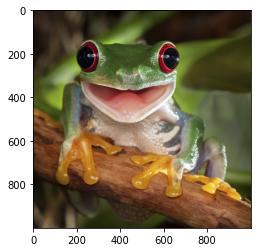

In [2]:
img_bgr = cv2.imread("images/happy-frog.jpg")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
height, width, n_channels = img.shape
print(f"width: {width} pixels")
print(f"height: {height} pixels")
print(f"channels: {n_channels}")
plt.imshow(img)
plt.show()

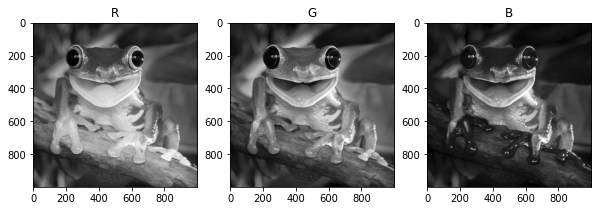

In [3]:
height, width, n_channels = img.shape
fig, axes = plt.subplots(figsize=(10,5), ncols=n_channels)
for ax, ch, title in zip(axes, np.rollaxis(img, axis=2), ["R", "G", "B"]):
    ax.imshow(ch, cmap="gray")
    ax.set_title(title)
plt.show()

In [4]:
def resize_image(img, target_sz):
    img : Image = Image.fromarray(img)
    width, height = img.size
    if width > height:
        aspect_ratio = target_sz[0] / width
    else:
        aspect_ratio = target_sz[1] / height
    new_width = math.floor(width * aspect_ratio)
    new_height = math.floor(height * aspect_ratio)
    return np.asarray(img.resize((new_width, new_height)))    

def show_pixels(img: np.ndarray, ch_idx: int):
    ch = img[:,:,ch_idx]
    height, width = np.shape(ch)    
    thresh = ch.max()/2.5   
    fig = plt.figure(figsize=(15,15))
    plt.imshow(ch, cmap="gray")
    for x in range(width):
        for y in range(height): 
            val = round(ch[y,x],2) if ch[y,x] !=0 else 0
            color = 'white' if val<thresh else 'black'
            plt.annotate(str(val), xy=(x,y),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color=color) 

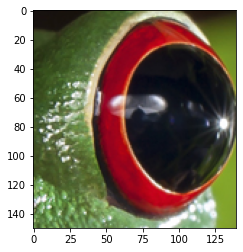

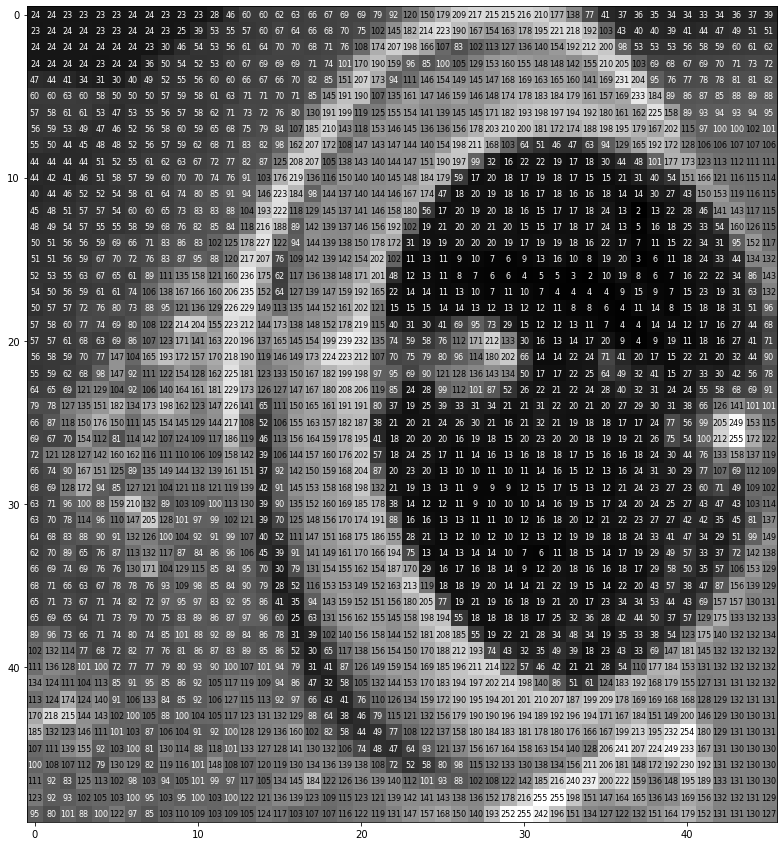

In [5]:
roi = cv2.selectROI(
        "src", img_bgr,
        fromCenter=False,
        showCrosshair=False)
x,y = roi[0], roi[1] 
w,h = x + roi[-2], y + roi[-1] 
roi_img = img[y:h, x:w]
plt.imshow(roi_img)
cv2.waitKey(0)
cv2.destroyAllWindows() 
roi_img = resize_image(roi_img, (50,50))
show_pixels(roi_img, 0)

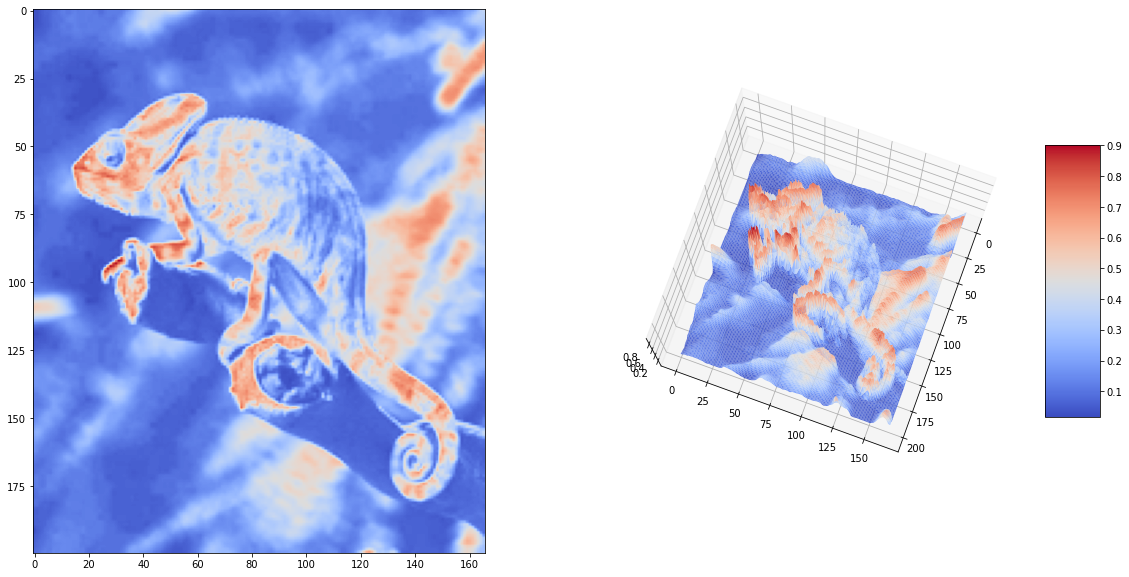

In [6]:
img_gray = cv2.imread("images/chameleon.jpg", cv2.IMREAD_GRAYSCALE)
img_gray = resize_image(img_gray, (200,200))
img_gray = img_gray / 255
height, width = img_gray.shape
xx, yy = np.mgrid[0:height, 0:width]
fig = plt.figure(figsize=(20,10))
ax_2d = fig.add_subplot(1, 2, 1)
ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
ax_2d.imshow(img_gray,cmap=plt.cm.coolwarm)
surf = ax_3d.plot_surface(xx, yy, img_gray ,rstride=1, cstride=1, cmap=plt.cm.coolwarm,linewidth=2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax_3d.view_init(80,20)
plt.show()

# Convoluciones

En procesamiento de señales a este tipo de operacion le conoce cross-correlation. Dicha operación esta definida como:

$$
S(i, j)=(I \star K)(i, j)=\sum_{m} \sum_{n} I(i-m, j-n) K(m, n)
$$

Donde la operación de convolución se denota por el símbolo $\star$, y se aplica sobre la imagen $I$, usando el kernel $K$. 
Sin embargo, casi todas las bibliotecas de aprendizaje automático y aprendizaje profundo utilizan la versión simplificada de dicha operación, definida como:

$$
S(i, j)=(I \star K)(i, j)=\sum_{m} \sum_{n} I(i+m, j+n) K(m, n)
$$

Toda esta matemática equivale a un cambio de signo en la forma en que accedemos a las coordenadas de la imagen, que evita que tengamos que "cambiar la  orientación" del kernel en relación con la imagen de entrada al aplicar la operación (esto dado que es más fácil entender un sistema de coordenadas definido por (0,0) como origen). Por lo tanto, dado que muchas bibliotecas de aprendizaje profundo usan la operación de correlación cruzada simplificada,  y además la llaman convolución, por conveniencia resulta más apropiado usar la misma terminología.

En conclusión, podemos asociar una imagen como una matriz de 3 dimensiones que define el ancho, alto y número de canales de la misma. Y un kernel como una matriz de menor tamaño que se utiliza para difuminar, resaltar, detectar bordes, entre otras funciones de procesamiento. Esta matriz conocida como kernel, se coloca encima de la imagen y se mueve de izquierda a derecha y de arriba a abajo, aplicando una operación matemática (para este caso una convolución), este proceso se repite para cada(x, y) par de coordenadas de la imagen.

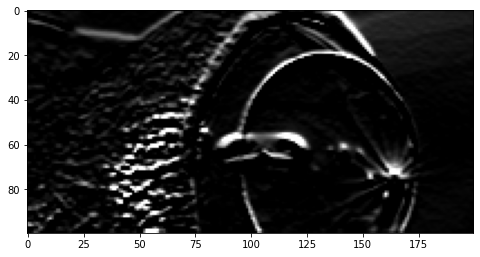

In [15]:
def convolve(image, K):
    # grab the spatial dimensions of the image and kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = K.shape[:2]
    # allocate memory for the output image, taking care to "pad"
    # the borders of the input image so the spatial size (i.e.,
    # width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad,cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top-to-bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            #perform the actual convolution by taking the
            #element-wise multiplication between the ROI and
            #the kernel, then summing the matrix
            new_pixel_value = (roi * K).sum()
            #update the output matrix
            output[y - pad, x - pad] = new_pixel_value
    # rescale the output image to be in the range [0, 255]
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    # return the output image
    return output


fig = plt.figure(figsize=(8,8))
gray = cv2.imread("images/happy-frog.jpg", cv2.IMREAD_GRAYSCALE)
gray = gray[150:250, 500:700]
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")
output = convolve(gray, sobelY)
plt.imshow(output, cmap="gray")
plt.show()

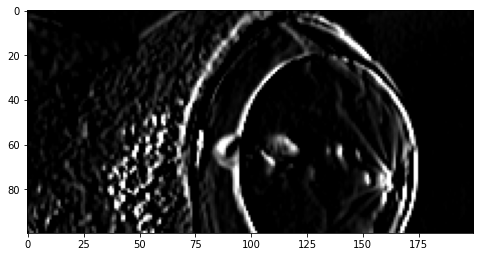

In [16]:
fig = plt.figure(figsize=(8,8))
gray = cv2.imread("images/happy-frog.jpg", cv2.IMREAD_GRAYSCALE)
gray = gray[150:250, 500:700]
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")
output = convolve(gray, sobelX)
plt.imshow(output, cmap="gray")
plt.show()

[INFO] applying small_blur kernel
[INFO] applying large_blur kernel
[INFO] applying sharpen kernel
[INFO] applying laplacian kernel
[INFO] applying sobel_x kernel
[INFO] applying sobel_y kernel


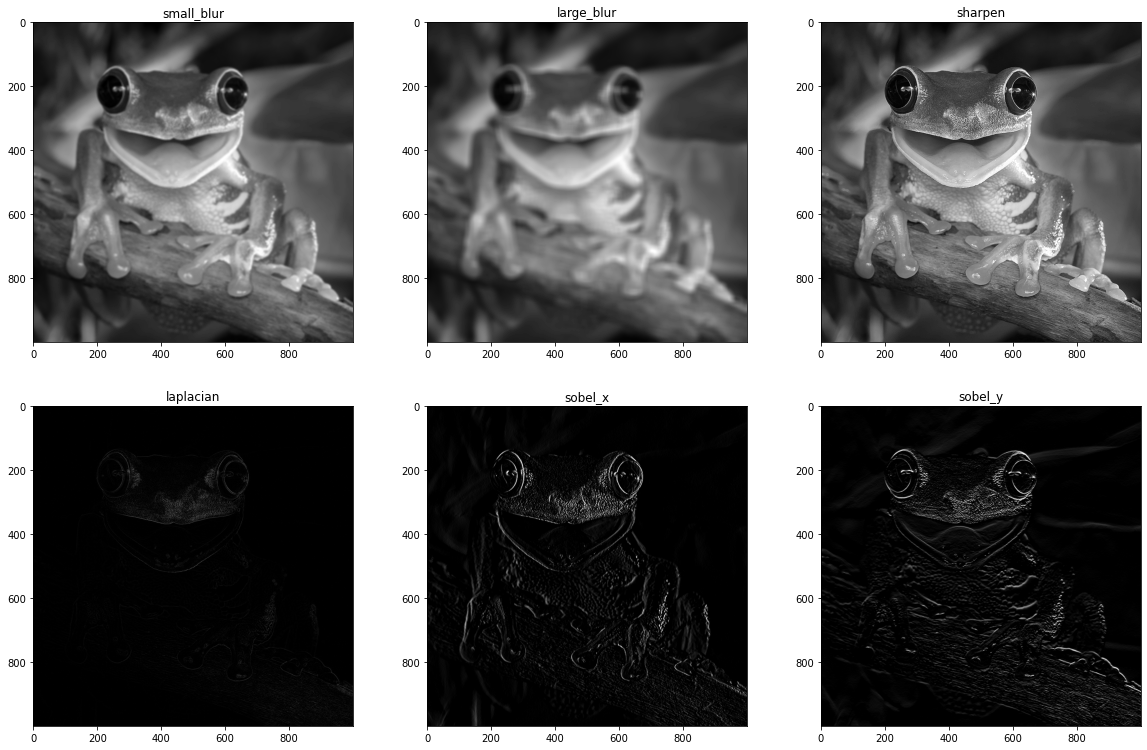

In [10]:
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))
# construct a sharpening filter
sharpen = np.array((
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]), dtype="int")

laplacian = np.array((
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]), dtype="int")
# construct the Sobel x-axis kernel
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")


kernelBank = (
    ("small_blur", smallBlur),
    ("large_blur", largeBlur),
    ("sharpen", sharpen),
    ("laplacian", laplacian),
    ("sobel_x", sobelX),
    ("sobel_y", sobelY)
)

fig = plt.figure(figsize=(20,20))
gray = cv2.imread("images/happy-frog.jpg", cv2.IMREAD_GRAYSCALE)
for i, (kernelName, kernel) in enumerate(kernelBank):
    print("[INFO] applying {} kernel".format(kernelName))
    dst = cv2.filter2D(gray, -1, kernel)
    ax = fig.add_subplot(3,3,i+1 )
    ax.set_title(kernelName)
    ax.imshow(dst, cmap="gray")
